# Libraries

In [1]:
# My library
import sarah1 as sa
# Basic libraries
import time
import numpy as np
import pandas as pd
# Data managements
import wfdb
# Statistics
import statistics as st
import statsmodels.api as sm
# Special functions
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
# Scikit-learn
from sklearn.metrics import mean_squared_error
from math import sqrt
# Plots
#import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"
# Widget
%matplotlib widget
# Theme
plt.style.use('ggplot')

# Read data

In [2]:
# Patient number
patient = "00"
# Define path to data
file = "/Users/jesus.fuentes/Developer/Data/LTAF_84P/" + patient
# Read data from binary files
data = wfdb.rdrecord(file)
# Assign ECG signals
ecgs = data.p_signal
# Determine the sampling frequency
f0 = data.fs
# Read only one ECG channel
ECG = ecgs[:, 0]
# Filter ECG signal via Butterworth
ECG = sa.filterECG(ECG, sampling_rate=f0)
# Open h5 file as pandas df
peak = pd.HDFStore('../LTAF_84P_stats/LTAF_84P-' + patient + '-t_width-60-peaks.h5')
# QRS complexes
rpeaks = []
for n in range( len(peak.keys()) ):
    rpeaks.append( peak['df' + str(n)]['R'] )
# Close file to free memory
peak.close()
# Sanitise peaks
nrpeak = [sa.removeNAN(rpeaks[n]) for n in range(len(rpeaks))]

# HRV analysis

In [3]:
# Compute intervals between R-peaks
RRI = [np.ediff1d(nrpeak[n], to_begin=0) / f0 for n in range(len(nrpeak))]
for n in range(len(RRI)):
    RRI[n][0] = np.mean(RRI[n])
# Normal-Normal (HR) and HRV
HRI = [60/RRI[n] for n in range(len(RRI))]
HRV = [np.ediff1d(HRI[n], to_begin=0) for n in range(len(HRI))]
# Basic RR features
MRR = [st.mean(RRI[n]) for n in range(len(RRI))]
VRR = [st.variance(RRI[n]) for n in range(len(RRI))]
SDRR = np.sqrt(VRR)
# Basic HRV features
MHRV = [st.mean(HRV[n]) for n in range(len(HRV))]
VHRV = [st.variance(HRV[n]) for n in range(len(HRV))]
SDHRV = np.sqrt(VHRV)

## Plots

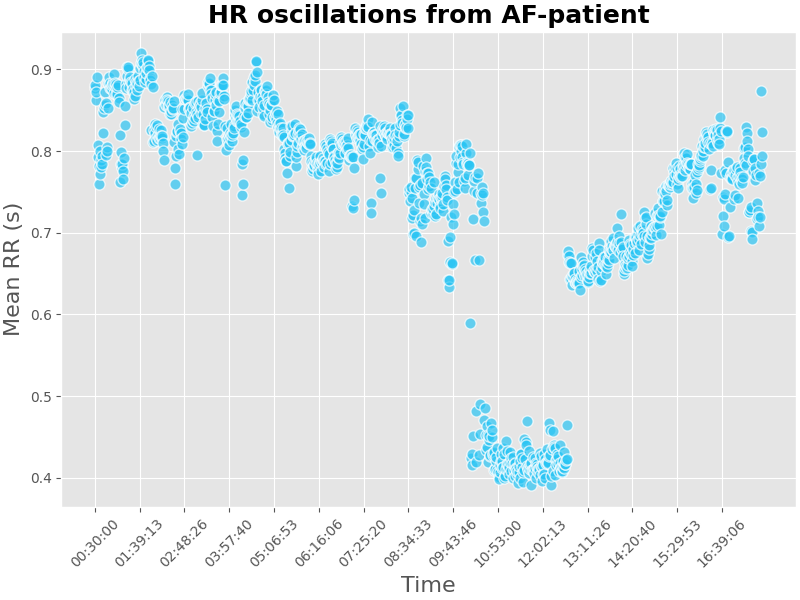

In [4]:
# Select HRV feature
feature = MRR
# The window is updated in intervals of:
winwidth = 50     # seconds
start_at = 30*60  # seconds
# Raw time
tr = winwidth * np.linspace(0, len(feature), num=len(feature)) + start_at
# Time with format
tt = [time.strftime('%H:%M:%S', time.gmtime(tr[i])) for i in range(len(tr))]
# Define figure
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
# Call plots
plt.plot(tr, feature, 'o', color='#2AC5F4', mec='w', ms=8, alpha=0.7)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Mean RR (s)', fontsize=16)
plt.xticks(tr, labels=tt, rotation=45)
plt.title('HR oscillations from AF-patient', fontsize=18, weight='bold')
plt.locator_params(axis="x", nbins=15)
plt.show()

# ARMA methods

In [5]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)
        
        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

## Autocorrelation plot (optional)

In [ ]:
# Plots
pd.plotting.autocorrelation_plot(pd.Series(MRR))
plt.show()

## Split data into psuedo RT-chunks

    Only consider a slice of data

In [130]:
lag0 = 0
nlag = 200
nbin = 50
# Select a slice of data
sample = MRR[lag0:lag0+nlag]
# Initialise pandas data frames
labs = pd.timedelta_range(start=(30*60+50*lag0)*10**9, freq='50S', periods=nlag)
index = pd.date_range('1800-01-01', freq='AS', periods=nlag)
#index = pd.array(np.arange(0,nlag))
data = pd.DataFrame(sample, index=index)
data.columns = ['MRR']
# Split into train and test sets
train, test = data[:nlag-nbin], data[nlag-nbin:nlag]

In [35]:
# Setup the model
model = LocalLinearTrend(train)
output = model.fit(disp=False)
print(output.summary())

                           Statespace Model Results                           
Dep. Variable:                    MRR   No. Observations:                  150
Model:               LocalLinearTrend   Log Likelihood                 364.452
Date:                Sun, 06 Feb 2022   AIC                           -722.903
Time:                        19:25:53   BIC                           -713.912
Sample:                    01-01-1800   HQIC                          -719.250
                         - 01-01-1949                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement   1.65e-11   3.19e-05   5.18e-07      1.000   -6.25e-05    6.25e-05
sigma2.level           0.0004    7.5e-05      5.479      0.000       0.000       0.001
sigma2.trend        

In [37]:
predict = output.get_prediction()
forecast = output.get_forecast('1999')

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


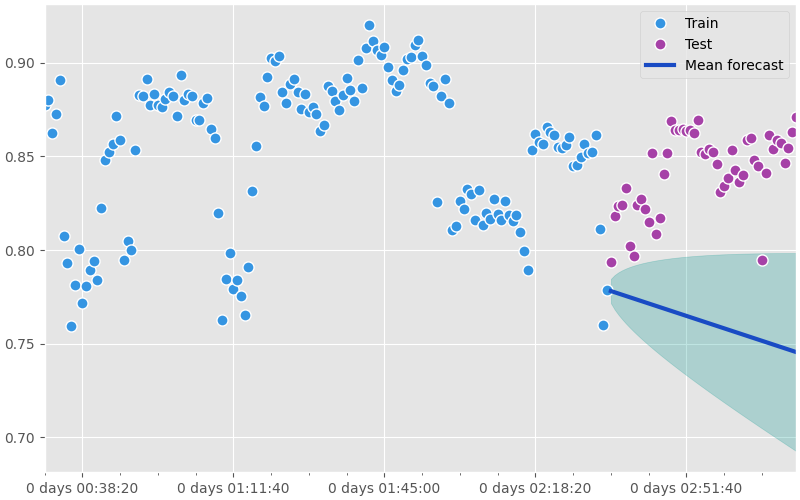

In [38]:
# Define figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
# Plot real data
train['MRR'].plot(ax=ax, style='o', ms=8, mec='w', color='#3595E2', label='Train')
test['MRR' ].plot(ax=ax, style='o', ms=8, mec='w', color='#A641A7', label='Test')
# Plot forecast
forecast.predicted_mean.plot(ax=ax, color='#194BC4', lw=3, label='Mean forecast')
# Configure range of confidence
f_conf = forecast.conf_int(alpha=0.75)
ax.fill_between(test.index, f_conf.iloc[:, 0], f_conf.iloc[:, 1], color='#02958E', alpha=0.25)
# Configure xticks
plt.xticks(index, labels=labs)
plt.locator_params(nbins=5)
ax.legend(loc='best')